## Quick Guide


The notebook works as a simple script that calls data from CDMNext using CEIC's Python package, extracts all series from the selected insight, gets all timepoints for these series, builds dataframe, and create a grid of interactive plots with the given dataframes


> #### Installation Guide
>
> 1. Install Python 3.9+
> 2. Open terminal and execute
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client --upgrade
---

> #### Usage Guide
>
> **Import libraries** - cell to define libraries we need to set before running the code<br />
> **Insight Information** - cell to define the insight we want to replicate<br />
> **Function Definitions** - to read or change the existing logic used by the main program<br />
> **DataFrames** - select the dataframes that are going to be plotted<br />
> **Code Execution** - run the main program based on parameters and functions<br />
> 
>
> Visit **[CEIC Main Page](https://www.ceicdata.com/en)** for more information on how to use our data and the PyCEIC package.
>

### Import Libraries

In [1]:
# Call the PyCEIC functionalities 
from ceic_api_client.pyceic import Ceic 
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.patches import Patch
import matplotlib.image as image
import matplotlib.image as mpimg
from pylab import *
import openpyxl
import numpy as np
import pandas as pd
import math

# Libraries nedded to include interactive widgets
from IPython.display import clear_output
from datetime import datetime

In [2]:
workbook = openpyxl.load_workbook(r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\credentials.xlsx')
sheet = workbook.active
user = sheet['A2'].value
pasw = sheet['B2'].value
Ceic.login(user,pasw)

C:\Users\necheverry\Anaconda3\lib\site-packages\ceic_api_client\facade\pyceic_warnings.py:83: UserWarning: 
interaction interface to CEIC macroeconomic data and
any data usage abuse attempt will be recorded.
  warnings.warn(message=self._WARNING_MESSAGE, category=UserWarning)


### Insight information

United States Inflation Nowcast
  <br>
id: 'f645159d-f17c-4917-a97a-966172f849eb'  <br>
Link: https://insights.ceicdata.com/United-States-Inflation-Nowcast

In [3]:
us_nowcast = ["6946f848-ff8f-4223-ac6c-130d30aab44e", "3a176274-13d3-414d-ba57-bd3acf471b0c", "e512f596-22b0-403b-b9d8-044a12c86de8", "03c61450-6f5e-467b-bdb4-1e5c53bdb17c", "9a84b2e7-0974-4f0d-aed6-06255625fbff", "c602a34d-92d5-4767-bda2-aa37cf7f57bf", "c7e5c788-099c-4957-95ea-34295338ed51", "631b45d1-5b43-4983-9aa8-9dd58b5da411", "ac4d9bba-5b73-44e5-b457-b317ca6e6f50", "7e94432e-8ba4-41ae-9943-7a8ac36664dc", "fcd69b64-91f0-4316-995f-133802879b70", "a83198e9-ddb0-4bf1-9224-2c340417b87d", "f1bb2cda-30c1-46e9-8f26-b1870dfbcfc0", "f7b142f3-6830-4c3b-b13f-5dbb745ce4e9", "b2aaf5b0-1cba-4e35-837b-2f070a40768d", "634f4cea-c68d-45d7-8006-be0415d039a9", "303c5e65-b65f-4608-8ea7-78ec3d6edcfd", "67855dd2-c543-4868-baa5-7d18a0e89dcc", "5eb16f8d-7145-4de0-ad33-39f2124d2516", "eea20a2c-e76c-4919-bcc5-b4ec6497cdc4", "112cb6f4-c9b7-480b-91ef-2eb17f09a610", "d5872e17-f941-459c-b89e-5272798fcff6", "6d609b0d-aaae-4673-bb9f-2e2d04731854", "6cd8dc27-c404-4dc7-a597-4ccab5e686fd", "6382b980-b76a-439f-9892-c506e159f7bc", "154ecee5-a7dc-424e-bb12-d9b197aab3c2", "e29bf0a4-e6b7-4cbc-92a9-a8c63195177b", "10220777-157d-4736-ba84-4da314dda513", 
              "b49a2e34-da79-4d9c-8c30-c2cb4d590e83", "643e2f67-dba1-48ef-a42d-31020fa85712", "b50b6638-c70f-4832-a3c8-57babc65ca6a", "029e3252-f622-4678-90d8-2d00fc17b074", "573f0cd4-6cf4-481a-b6c2-dfdb9fc0137b", "e084c710-ab48-45b8-b7a5-c098b088fb26", "ff2875d3-9e0f-4b22-8294-2b173da0292d", "823cdbbd-d7de-49ab-8ac6-dc252fa7367d", "fc16f6ed-dc21-4190-a5c2-0481417b87fa", "64ddb8fa-41d5-486f-ab1f-6b3391d4ad85", "4eb678bc-529f-49e6-bebe-c6ccc9621fde", "68d2c0ec-a431-430d-89e0-1627f1babba8", "ceb7d695-14af-48be-93f2-538b6031ed1c", "15a3e0ad-6e3f-4c33-82ef-e9e9c7c47f16", "bdb2c962-a732-4d56-899a-e56843e7cd11", "ad18e476-b745-496b-b07f-289d0f732480", "e819ab85-5548-44a2-b8cb-05cedc72caa3", "c73eed71-8d92-4666-8fb2-14cb086bff3c", "e3f9ee62-bfb3-4024-8901-494ac46930d3", "bade54ce-08d8-4f46-a562-2d34e18e1c03", "0d2609e7-d58e-4c73-8945-3153b5ae8a1e", "cbd929ef-cb24-4210-a0f8-0da4456fa98c", "c4117aaf-76b4-4e9b-a5e4-fe45b987469d", "0f2312ec-9551-4d19-9b89-194a2785cbad", "d1d64c72-84e1-46c2-95e6-c5896ba4c036", "b05c4da7-a966-4487-8e6c-c16c21d7b7fe", "b343ed38-da0f-4411-9092-8b63a6963b2f", "13edb5e1-8b94-41a5-a3ac-d1263dba204f", 
              "864fa0c8-227d-465f-bea4-8c9438914147", "78c21639-a944-4fa7-8aa8-6537f00adee2", "b73a703e-991f-4b22-b30c-cbd5f18a087f", "d4ecb0ef-abe2-4f4b-a377-76f31891b41d", "4e651d33-4f67-47d9-b67b-ad5b476b4346", "a14d9dc3-30cd-40c2-a5d5-9a39bcc6b3c0", "b0b86eb7-dbb7-4a49-83b7-473bbae85522", "7bdf1ac9-012b-4c73-9edb-cabd55216b71", "6a21d73c-15a2-43bf-ad1b-163eb00b05a9", "166452ae-e7fc-438f-befc-b402ed0a9bc4", "7dc2fb2d-c533-48a7-b26e-8ba1ac9df109", "3fdc77ea-61da-43b6-8cca-f03b68b304a9", "bf1abafb-989a-44b0-ba72-3b39fe18973d", "d3ff3b4d-1772-41c3-b34a-fa6a9cbad6b6", "41c23d27-4a91-4253-8d74-3161ef557e6b", "33c4041e-2508-4b82-b444-1723838b7e54", "1a6bd54f-9114-49b2-b2e5-557cddeae0a1", "4f375879-cecd-4000-8015-aa463ec2cbab", "e47f9457-d1c1-468a-b017-4583075fd741", "7f9f765d-1b6d-40df-b57b-cc4ff0a76b99", "dec1bae0-017e-4760-a1ee-8a7b13ad77b2", "e1df134b-ea0c-4b2c-b1e0-9a1c2529bb04", "ce330d09-c156-478b-afaa-de75ed1e93fe", "41ebdaf7-24a9-4044-b963-8491755e712c", "fbf0092e-3fad-4324-952e-0c5f322e5c05", "846f905e-2b61-4924-9d40-605afd767169", "a1a94d4a-8b10-4f61-a718-6fe2cac6eca3", "f8ada559-a247-410e-837e-a4e98329d814", 
              "703bf661-7604-469f-83aa-d7d64a81f10d", "e279978d-c741-48f8-9e4e-241091f1fe8f", "fb9b0a4d-241e-4e6f-a344-96965f05e4c5", "ee61ffb4-0f59-4d02-965e-b97ecfb8b444", "edf4e7c4-aada-4bb1-9b8d-71759e835756", "555e91b5-02c8-4c30-9a2b-46e71801acbf", "a6a881b4-5b56-4329-9531-4193f4a9d8b1", "316a7e5e-7565-4b1a-85c6-3fdfbf4a39db", "f51bd261-9261-4870-8903-738204862fb1", "0e068141-41bd-4828-8140-4b4e2817f7d5", "7d6a968b-f377-4a34-86ae-ef7878e57d3d", "28fc0e1e-8ee1-48fa-966e-8636b69bfe27", "f3c02ff1-9cfb-4116-8e00-c3bad692e2c1", "77c6a04c-1621-436d-9a72-c5b19ce24d82", "99aa407c-9270-40e5-baab-4f8fe3f4c79f", "5650a73b-8503-473e-98ff-f3f3b86674f7", "38331d34-27dd-4bf7-a825-c187da0fdf60"]

In [4]:
def get_series_to_df(id_insight):
    
    '''This function takes the id of an insight as an 
    argument and downloads the series associated with the insight. 
    After that the series are stored in a DataFrame depending 
    on the frequency(daily,weeklr or monthly).'''
    
    series_d, series_w, series_m = {},{},{} # Dictionaries for each type of frequencies
    
    codigos = [i for i in id_insight]

    # Dividir la lista en sub-listas de 20 elementos
    sub_listas = [codigos[i:i + 20] for i in range(0, len(codigos), 20)]

    # Download each sublist
    for sub_lista in sub_listas:
        result = Ceic.series(sub_lista)
        
        for s in result.data:
            if s.series_data != None:
                if s.insight_series.applied_functions != None:
                    column = s.series_data.metadata.name + ': ' + s.insight_series.applied_functions
                else:
                    column = s.series_data.metadata.name
                time_points_dict = dict((tp._date, tp.value) for tp in s.series_data.time_points)
                series = pd.Series(time_points_dict)

                if s.series_data.metadata.frequency.id == 'D':
                    series_d[column] = series
                elif s.series_data.metadata.frequency.id == 'W':
                    series_w[column] = series
                elif s.series_data.metadata.frequency.id == 'M':
                    series_m[column] = series
    
    df_daily = pd.DataFrame(series_d)
    df_weekly = pd.DataFrame(series_w)
    df_month = pd.DataFrame(series_m)
    
    # Converting the index as date
    df_daily.index = pd.to_datetime(df_daily.index)
    df_weekly.index = pd.to_datetime(df_weekly.index)
    df_month.index = pd.to_datetime(df_month.index)
    
    # Sort by date
    df_daily = df_daily.sort_index(ascending=True)
    df_weekly = df_weekly.sort_index(ascending=True)
    df_month = df_month.sort_index(ascending=True)
    
    return df_daily, df_weekly, df_month           

In [5]:
us_now_d, us_now_w, us_now_m, = get_series_to_df(us_nowcast)

In [6]:
def draw_chart():
    
    # Rename some columns for convenience
    us_now_m.rename(columns = {'Consumer Price Index: Urban: %CHANGE(Over Year)':'Consumer Price Index: YoY'}, inplace = True)
    us_now_m.rename(columns = {'US Inflation Nowcast: AGGREGATE(Monthly; Last day of month; Avg; Yes)':'US Inflation Nowcast: Monthly'}, 
                           inplace = True)
    us_now_w.rename(columns = {'US Inflation Nowcast: MOVAV(Simple; 4)':'US Inflation Nowcast: Weekly'}, inplace = True)

    #Create a color pallette
    ceic_palette = ['#884b8f','#05999a','#a2c96a','#ff5b4d','#34224a','#2b60d0','#fda546',
                '#a7a5a3','#ffec61','#823a1c']
    
    #CEIC logo
    im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
    img = mpimg.imread(im)
    
    #Start the figure
    fig = plt.figure(figsize=(15, 30), edgecolor='none', facecolor='white')
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.4, wspace=0.2)

    # Define your subplots
    ax1 = fig.add_subplot(gs[0, 0]) # Top left
    ax2 = fig.add_subplot(gs[0, 1]) # Top right
    ax3 = fig.add_subplot(gs[1, :]) # Bottom, full width
    ax4 = fig.add_subplot(gs[2, :]) # Bottom, full width
    ax5 = fig.add_subplot(gs[3, :]) # Bottom, full width

    # Charts
    # Inflation Nowcast, monthly
    us_now_m['US Inflation Nowcast: Monthly']['2021-08-01':].plot(ax=ax1, color='#884b8f', style='-o')
    us_now_m['Consumer Price Index: YoY']['2021-08-01':].plot(ax=ax1, color='#05999a', style='-o')
    ax1.set_title('Inflation Nowcast, monthly', pad=25, size=20, font='roboto', weight='bold')
    ax1.grid(color='grey', alpha=0.2, linestyle='--')
    ax1.annotate('United States', xy=(0.5, 1.03), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    #Logo
    ax1_img1 = fig.add_axes([0.47, 0.67, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax1_img1.imshow(img)
    
    #Legend
    ax1.legend(labels=['Monthly Nowcast','Consumer Price Index, % y/y'],loc='upper center', 
               bbox_to_anchor=(0.5, -0.1), ncol=2, edgecolor='none')
    
    
    # Inflation Nowcast, weekly
    us_now_w['US Inflation Nowcast: Weekly']['2022-10-01':].plot(ax=ax2, color='#884b8f', style='-')
    us_now_m['Consumer Price Index: YoY']['2022-10-01':].plot(ax=ax2, color='#05999a', style='-')
    ax2.set_title('Inflation Nowcast, weekly', pad=25, size=20, font='roboto', weight='bold')
    ax2.grid(color='grey', alpha=0.2, linestyle='--')
    ax2.annotate('United States', xy=(0.5, 1.03), xytext=(0, 0),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    #Logo
    ax2_img1 = fig.add_axes([0.88, 0.67, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax2_img1.imshow(img)
    
    #Legend
    ax2.legend(labels=['Weekly Nowcast','Consumer Price Index, % y/y'],loc='upper center', 
               bbox_to_anchor=(0.5, -0.1), ncol=2, edgecolor='none')
    
    #Text box
    ax3.set_title('CEIC Nowcast: United States Inflation Projected to Slow Down in October', 
                  pad=0, size=20, font='roboto', weight='bold')
    
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_frame_on(False)
    
    text_analysis = "Inflation in the US is projected to decelerate in October to 3.4% y/y from 3.7% y/y, according to CEIC’s proprietary \n inflation nowcast. If materialized, this would be the first slowdown since June. Price growth in the United States \nhas been accelerating for three months straight, with the September figure matching the August one at 3.7% y/y. \n\nCEIC's proprietary nowcast estimates inflation weekly by utilising a proprietary machine-learning framework \nbased on alternative data. The 4-week moving average points that inflation is stabilizing at 3.4% y/y for four \nconsecutive weeks as of the week of November 6th. \n\nCEIC’s machine-learning nowcast model enables the identification of the underlying factors influencing inflation dynamics. \nFor United States’ inflation, labour market indicators remain the strongest predictor of price growth, explaining 86.4% \nof the nowcast in September, followed by monetary variables (10.8%)."
    
    ax3.text(0, 0.5, text_analysis, transform=ax3.transAxes, fontsize=15, va='center', ha='left', wrap=True,
             bbox=dict(facecolor='none', alpha=0.5, edgecolor='none',boxstyle='round,pad=1'))
    

    # Contribution to Inflation Nowcast, Factors.
    ax4.set_title('Contribution to Inflation Nowcast, Factors', 
                  pad=25, size=20, font='roboto', weight='bold')
    
    ax4.grid(color='grey', alpha=0.2, linestyle='--')
    ax4.annotate('United States', xy=(0.5, 1.03), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    
    us_now_ind = us_now_w.loc[:,['US Inflation Nowcast: Financial: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Oil Prices: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Interest Rates: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Commodity Prices: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Monetary: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Labour Market: MOVAV(Simple; 4)',
                              'US Inflation Nowcast: Real Economy: MOVAV(Simple; 4)']]
    
    us_now_ind.columns = [x.replace('US Inflation Nowcast: ','') for x in us_now_ind.columns]
    us_now_ind.columns = [x.replace(': MOVAV(Simple; 4)','') for x in us_now_ind.columns]
    
    area = us_now_ind.plot.area(ax=ax4, color=ceic_palette[:len(us_now_ind.columns)])
    
    #Legend
    ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, edgecolor='none')
    
    #Logo
    ax4_img1 = fig.add_axes([0.88, 0.25, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax4_img1.imshow(img)
    
    # Contribution to Inflation Nowcast, All Indicators.
    us_now_ind_d = us_now_d[:]
    us_now_ind_d.update(us_now_ind_d[:].astype(float)) # We need dayta as float to select number of decimals
    us_now_ind_d.update(us_now_ind_d[:].applymap('{:,.2f}'.format))
    us_now_ind_d.columns = [x.replace('US Inflation Nowcast: ','') for x in us_now_ind_d.columns]

    #Traspose the dataframe to have dates as columns
    us_now_ind_d = us_now_ind_d.tail(5) 
    ind_d_transposed = us_now_ind_d.T
    ind_d_transposed.columns = [x.strftime('%Y-%m-%d') for x in ind_d_transposed.columns]
#     ind_d_transposed.columns = [x.replace(' 00:00:00','') for x in ind_d_transposed.columns]
    
    table = ax5.table(cellText=ind_d_transposed.values, rowLabels=ind_d_transposed.index, colLabels=ind_d_transposed.columns, 
                      loc='best')
    
    # Some customizations
    table.auto_set_font_size(False)
    table.set_fontsize(10)
#     table.scale(1, 1)
    
    # Color de fondo y texto para las celdas regulares
    regular_cell_color = 'white'  # Oscuro
    regular_text_color = 'black'

    # Color de fondo y texto para los encabezados y los índices
    header_index_cell_color = '#884b8f'  # Claro
    header_index_text_color = 'white'

    # Aplicar estilos a todas las celdas
    for key, cell in table.get_celld().items():
        if key[0] == 0 or key[1] == -1:  # Encabezados de columna o fila de índices
            cell.set_facecolor(header_index_cell_color)
            cell.set_text_props(color=header_index_text_color)
        else:  # Celdas regulares
            cell.set_facecolor(regular_cell_color)
            cell.set_text_props(color=regular_text_color)
            
    # Ajustar el ancho de las columnas
    num_cols = len(ind_d_transposed.columns) #+ 1  # +1 para la columna del índice
    total_table_width = 1.0  # Ajusta este valor según sea necesario
    col_width = 0.1

    for (i, cell) in enumerate(table.get_celld().values()):
        cell.set_width(col_width)
    
    ax5.set_title('Contribution to Inflation Nowcast, All Indicators', pad=25, size=20, font='roboto', weight='bold')

    # Opcional: Ocultar los ejes
    ax5.axis('off')
    
    #Logo
    ax5_img1 = fig.add_axes([0.88, -0.23, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax5_img1.imshow(img)

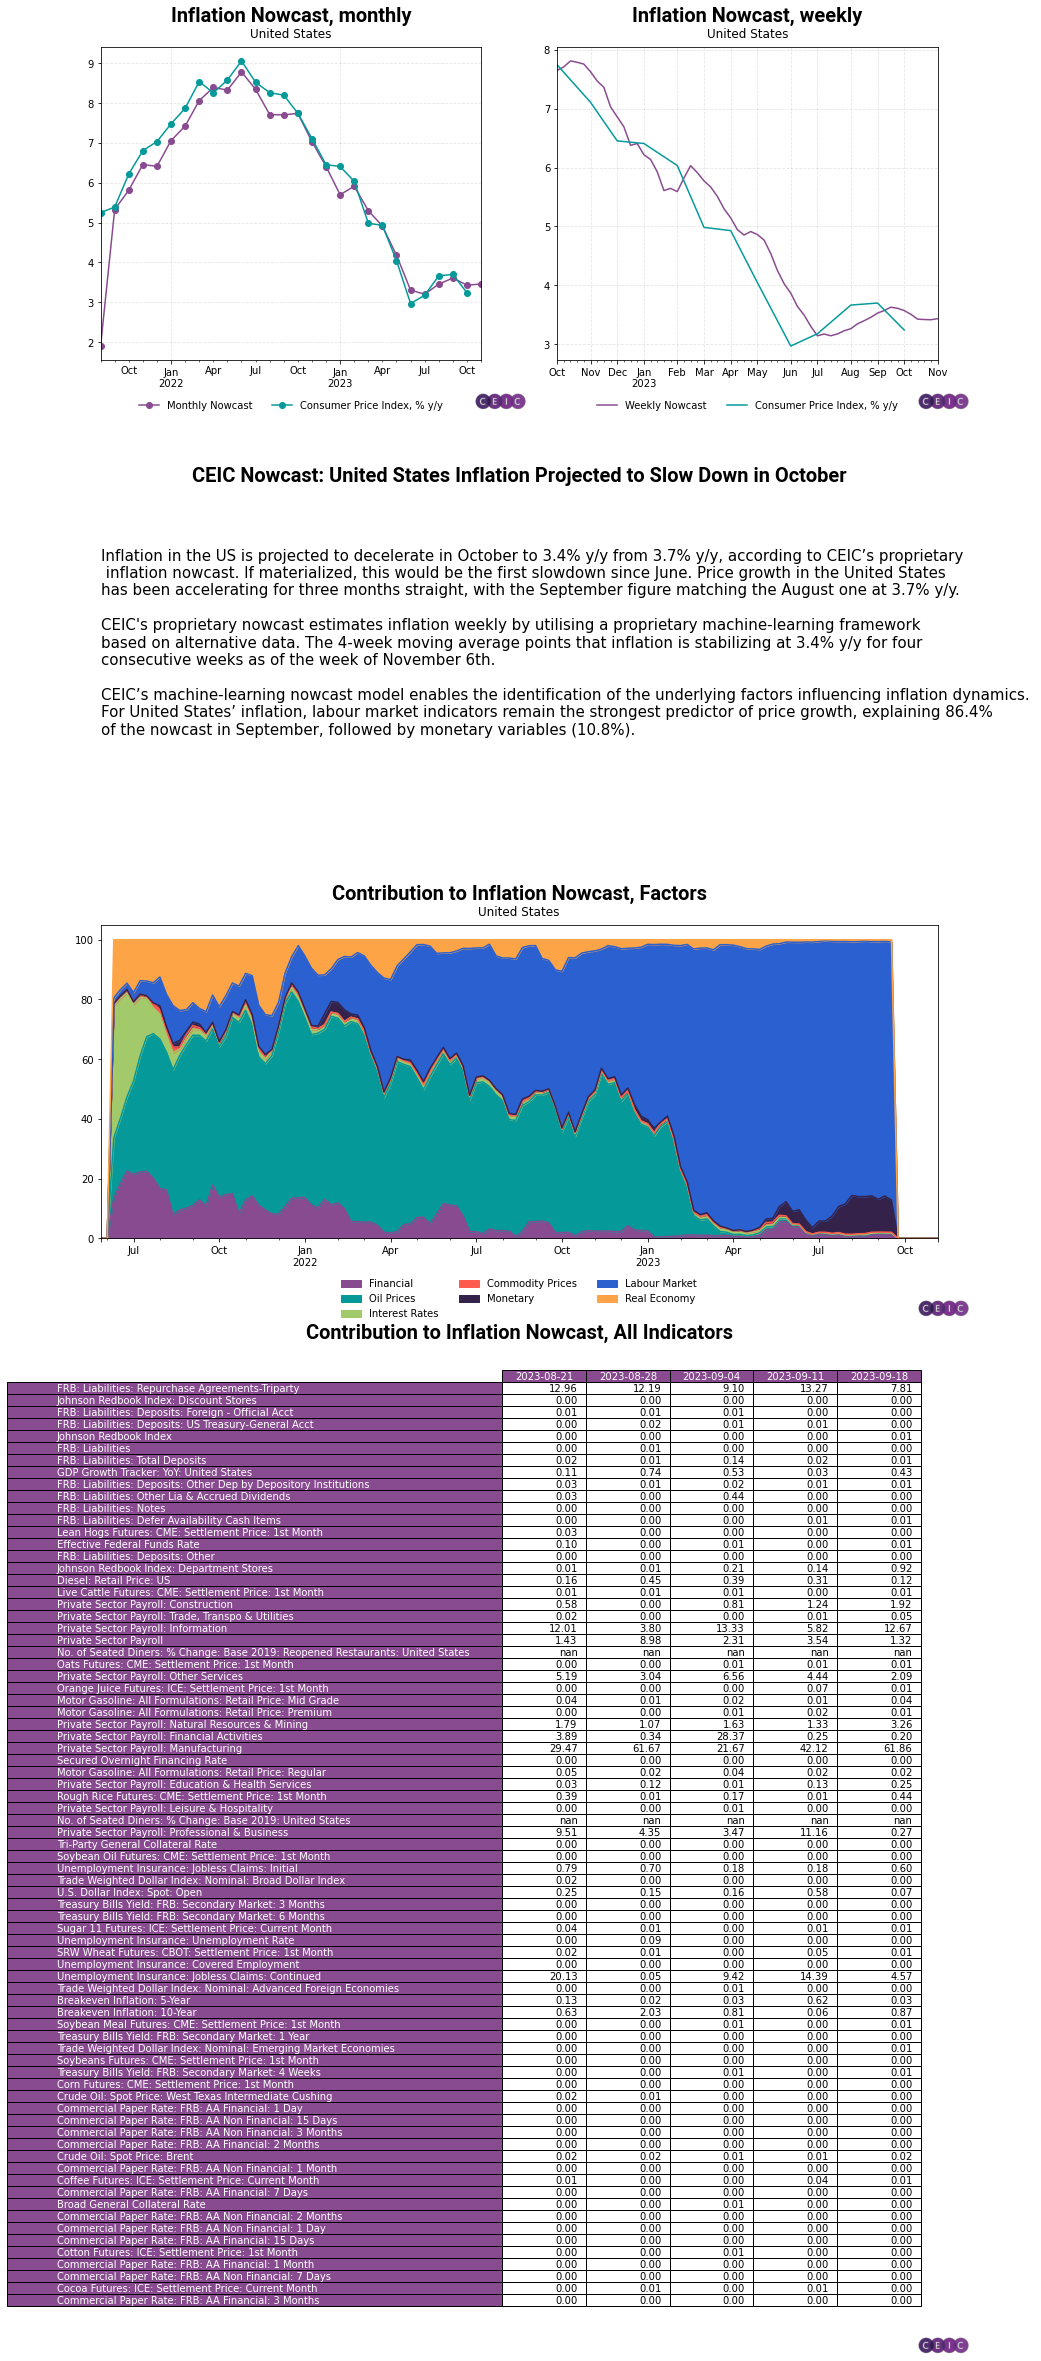

In [7]:
draw_chart()